# Introduction

We are going to try and model the strictly come dancing judges scores using multilevel linear regression and the people in the dance off following the public vote using multilevel logistic regression to see if there are any patterns based on the demographics of the celebrity dancers.

Data came from here:

* https://en.wikipedia.org/wiki/Strictly_Come_Dancing#Main_series_results
* https://en.wikipedia.org/wiki/List_of_Strictly_Come_Dancing_contestants


In [1]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import scipy.stats as sst

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# load the data
data = pd.read_csv("SCD_Series18.csv")
data_demo = pd.read_csv("SCD_celebrity_demographics.csv")
data_results = pd.read_csv("results_cleaned.csv", encoding="cp1252")

First up, we read the data in and join it so there is one row per dance in the data table. There's a little bit of set up to create the columns that will be used for the join in the demographic table. 

In [3]:
data_demo["Couple"] = (data_demo["Celebrity"].map(lambda x: x.split(" ")[0]) 
                       + " & " 
                       + data_demo["Professional"].map(lambda x: x.split(" ")[0]))
data = pd.merge(
    data,
    data_demo,
    left_on=["Couple", "Series"],
    right_on=["Couple", "Series"],
    how="left"
)

The results table needs quite a bit of cleaning, mostly because there are some errors / differences in convention about how the names of the dancers are recorded. 

In [4]:
# bit more cleaning on the results data

data["Couple"] = data["Couple"].map(
    lambda x: x.replace("Aljaz", "Aljaž")
)

# If missing result is in week 2 or before, assume NOONE left.
data_results.loc[
    np.logical_and(data_results["Result"].isnull(), data_results["Week"] <= 2), "Result"
] = data_results[np.logical_and(data_results["Result"].isnull(), data_results["Week"] <= 2)].fillna("Safe")

# If missing result is after week 2, assume it's because of multiple dances per show
data_results["Result"] = data_results["Result"].ffill()

data_results["Couple"] = data_results["Couple"].ffill()
data_results["Couple"] = data_results["Couple"].map(lambda x: x.replace(" and ", " & "))
data_results["Couple"] = data_results["Couple"].replace(
    "Cristopher & Hanna", "Chris & Hanna"
).replace(
    "Christopher & Hanna", "Chris & Hanna"
).replace(
    "Dennis & Izabela", "Dennis & Izabella"
).map(
    lambda x: x.replace("Aljaz", "Aljaž")
).map(
    lambda x: x.replace("Emma W.", "Emma")
).map(
    lambda x: x.replace("Emma B.", "Emma")
).map(
    lambda x: x.replace("2", "")
).map(
    lambda x: x.replace("1", "")
).map(
    lambda x: x.replace("Judge Rinder", "Robert")
).map(
    lambda x: x.replace("Rev. Richard", "Richard")
).map(
    lambda x: x.replace("Dr. Ranj", "Ranj")
).map(
    lambda x: x.replace("& Ian Waite", "& Ian")
)

In [5]:
data = pd.merge(
    data,
    data_results,
    left_on=["Couple", "Series", "Week"],
    right_on=["Couple", "Series", "Week"],
    how="left"
)

At this point we have a data table with more or less everything we need for the analysis. There are a few rows with missing data that will get dropped when the analysis is done and if could probably be fixed with more cleaning rules above...

In [6]:
# display rows with missing Result column
data.loc[data["Result"].isnull(), :]

,#,Couple,Dance_x,Song,Date,Series,Week,Order,Craig,Arlene,...,Place,Dances,Best score,Worst score,Aggregate,Average,Score,Dance_y,Music,Result
1494,1117,Natalie & Artem,Jive,Proud Mary,"Series 11, Week 07",11,7,7,-,-,...,=2nd/15,15.0,40.0,31.0,553.0,36.87,NaN,NaN,NaN,NaN
1878,1437,Kellie & Kevin,Rumba,Songbird,"Series 13, Week 12",13,12,5,9,-,...,=2nd/15,16.0,40.0,27.0,545.0,34.06,NaN,NaN,NaN,NaN
1887,1442,Kellie & Kevin,American Smooth,Let's Face The Music and Dance,"Series 13, Week 12",13,12,10,9,-,...,=2nd/15,16.0,40.0,27.0,545.0,34.06,NaN,NaN,NaN,NaN
2504,1936,Will & Janette,Jive,Casper The Friendly Ghost,"Series 17, Week 6",17,6,-,-,-,...,10th/15,5.0,32.0,23.0,129.0,25.80,NaN,NaN,NaN,NaN
2514,1955,Will & Janette,Waltz,Weekend In New England,"Series 17, Week 7",17,7,NaN,-,-,...,10th/15,5.0,32.0,23.0,129.0,25.80,NaN,NaN,NaN,NaN
2628,-,Nicola & Katya,American Smooth,Stand By Me,"Series 18, Week 4",18,4,DND,-,-,...,10th/12,3.0,32.0,25.0,85.0,28.33,NaN,NaN,NaN,NaN


We need some dummy columns for the dance type (a column that is 0 or 1, a flag) representing whether or not the dance was in that particular category. The "reference" dance if all the other flags are 0 will be ballroom.

In [7]:
# initial cleaning 
inds = [x in ["Ballroom", "Fusion", "Latin", "Speciality"] for x in data["Type"]]
data = data.loc[inds, :]

Thankfully, there is only one given name that both a male and a female celebrity had, handled in a special case below.

In [8]:
# Add flag for female celebrity.

data["Female_celebrity"] = data["Couple"].map(lambda x: x.split("&")[0].strip() in 
    ['Abbey', 'Alesha', 'Alex', 'Alexandra', 'Ali',
    'Alison', 'Anastacia', 'Anita', 'Ann', 'Anneka',
    'Carol', 'Caroline', 'Catherine', 'Charlotte',
    'Chelsee', 'Cherie', 'Chizzy', 'Christine', 'Claire',
    'Clara', 'Claudia', 'Daisy', 'Dani',
    'Debbie',
    'Deborah', 'Denise', 
    'Edwina', 'Emma', 'Esther', 'Faye', 'Felicity', 'Fern',
    'Fiona', 'Frankie', 'Gabby', 'Gemma', 'Georgia',
    'Georgina', 'Gillian', 'Gloria', 'Goldie', 
    'Heather', 'Helen', 'Holly',
    'Jacqui', 'Jade', 'Jamelia',
    'Jan', 'Jaye', 'Jennifer',
    'Jerry', 'Jessie', 'Jill', 'Jo', 'Jodie', 
    'Judy', 'Kara',
    'Kate', 'Katie', 'Kellie', 'Kelly', 
    'Kimberley', 'Kirsty', 'Laila', 'Laura', 'Lauren', 'Lesley',
    'Letitia', 'Lisa', 'Louisa', 'Louise', 'Lulu', 'Lynda',
    'Maisie', 'Martina', 
    'Mica', 'Michelle', 'Mollie', 'Naga',
    'Nancy', 'Natalie', 'Natasha', 'Nicola',
    'Pamela', 'Patsy', 'Penny',
    'Pixie', 'Rachel', 'Ranvir', 
    'Ruth', 'Saffron', 'Sarah',
    'Siobhan', 'Sophie', 'Stacey', 'Stephanie',
    'Sunetra', 'Susan', 'Susanna', 'Susannah', 'Tameka',
    'Tina', 'Vanessa', 'Verona', 'Vick',
    'Victoria', 'Zoe']
).astype(int)

# there is a male Ashley and a female Ashley, so this is a special case
data.loc[data["Couple"] == "Ashley & Pasha", "Female_celebrity"] = 1


In [9]:
def string_to_type(x, t=int):
    try:
        return t(x)
    except:
        return None

In [10]:
# Final bit of cleaning: divide the total score by the number of judges so all the scores have the same max and min
# We'll also set the max score to 40, since IIRC most of the time there were 4 judges.
data["Total"] = data["Total"].map(lambda x: string_to_type(x, float))

data["Total"] = 4.0 * data["Total"] / (
    data[['Craig', 'Arlene', 'Darcey', 'Len', 'Alesha', 'Shirley', 'Guest','Motsi', 'Bruno']] != "-"
).sum(axis=1)

At this point we have a data table with more or less everything we need for the analysis. There are a few rows with missing data that will get dropped when the analysis is done and if could probably be fixed with more cleaning rules above...

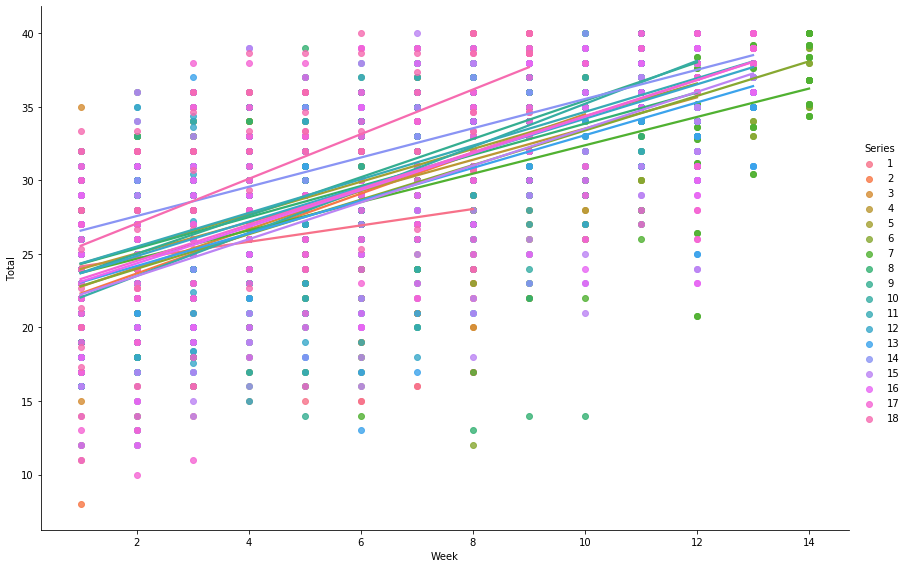

In [11]:
%matplotlib inline 
sns.lmplot(
    data=data[["Series", "Week", "Total"]],
    x="Week",
    y="Total",
    hue="Series",
    ci=None,
    height=8,
    aspect=1.5
)
plt.show()

We will use a multilevel model. This is because I want to treat each series separately, since the judges changed a few times over the course of the show. In a multilevel model, each group is fitted with a gradient and intercept separately in case the within group relationships are different.

In [12]:
multilevel_data = data[["Total", 'Week', 'Series', 'Order', "Female_celebrity", "Age", "Celebrity_BAME"]]

multilevel_data = pd.merge(
    multilevel_data,
    pd.get_dummies(data["Type"], prefix="Type"),
    left_index=True,
    right_index=True
)

for k in multilevel_data.keys():
    multilevel_data[k] = multilevel_data[k].map(lambda x: string_to_type(x, float))
    
md = smf.mixedlm(
    "Total ~ Order  + Female_celebrity + Age + Celebrity_BAME + Type_Fusion + Type_Latin + Type_Speciality", 
    multilevel_data, 
    groups=multilevel_data["Series"],
    re_formula="~(1 + Week)",
    missing="drop"
)
mdf = md.fit()
print(mdf.summary())

           Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  Total     
No. Observations:   2660     Method:              REML      
No. Groups:         18       Scale:               19.4113   
Min. group size:    80       Log-Likelihood:      -7785.6963
Max. group size:    211      Converged:           Yes       
Mean group size:    147.8                                   
------------------------------------------------------------
                 Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept        30.433    1.306  23.302 0.000 27.873 32.992
Order             0.221    0.027   8.104 0.000  0.168  0.275
Female_celebrity  1.474    0.177   8.345 0.000  1.128  1.820
Age              -0.152    0.009 -17.303 0.000 -0.169 -0.134
Celebrity_BAME    0.791    0.230   3.435 0.001  0.340  1.242
Type_Fusion      -0.798    1.862  -0.429 0.668 -4.448  2.852
Type_Latin       -1.925    0.203  -9

Lets check the residuals to make sure the model assumptions are not violated. 

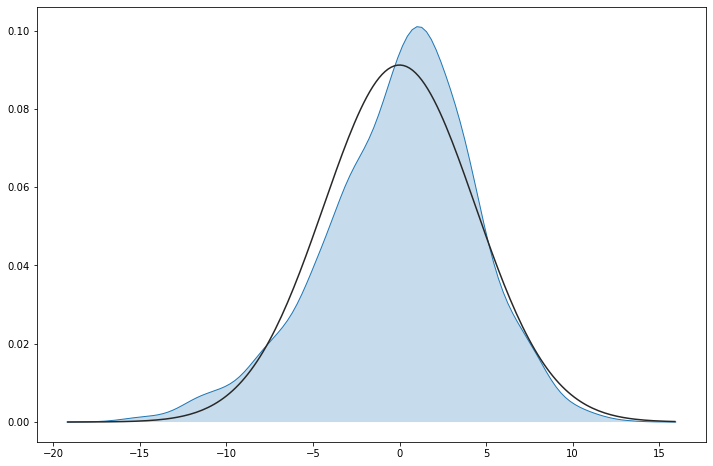

In [13]:
# normality of residuals

fig = plt.figure(figsize=(12, 8))
ax = sns.distplot(mdf.resid, hist = False, kde_kws = {"shade" : True, "lw": 1}, fit = sst.norm)
plt.show()

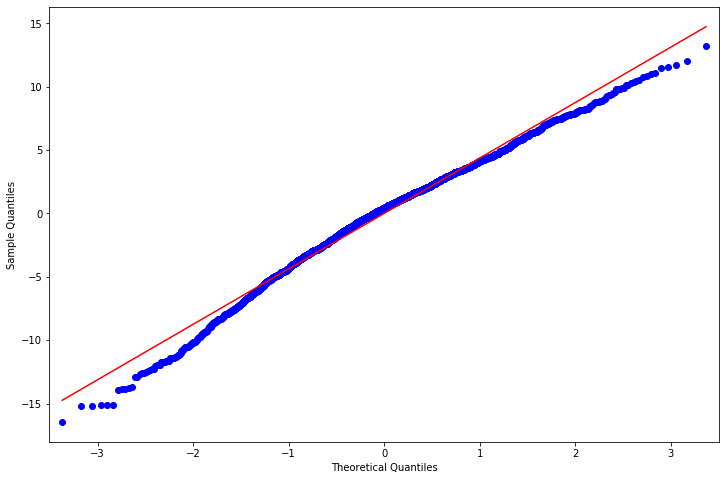

In [14]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax = sm.qqplot(mdf.resid, dist = sst.norm, line = 's', ax = ax)
plt.show()

In [15]:
labels = ["Statistic", "p-value"]

norm_res = sst.shapiro(mdf.resid)

for key, val in dict(zip(labels, norm_res)).items():
    print(key, val)

Statistic 0.9880484938621521
p-value 3.744103483738041e-14


Visually it doesn't look too bad to me (there is a slight skew), but the Shapiro Wilk test indicates the normality assumption is violated. 

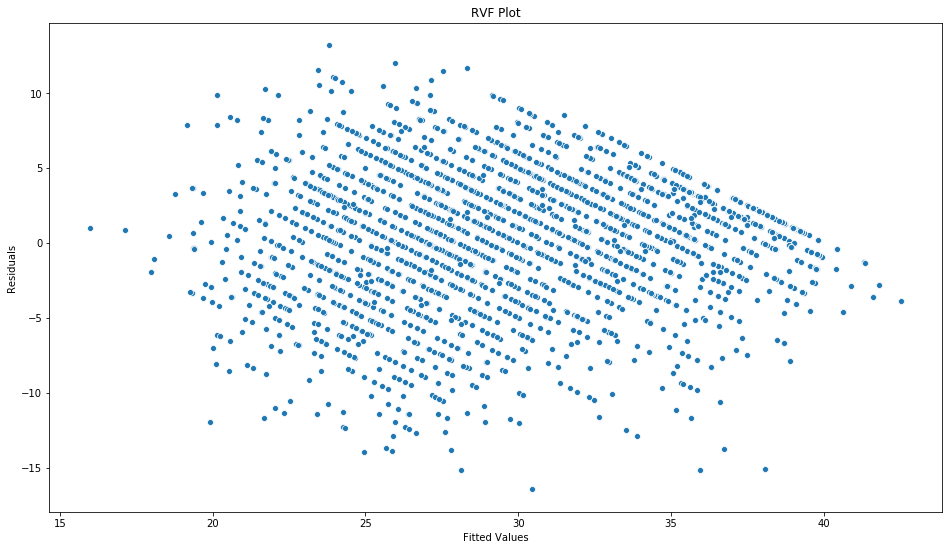

In [16]:
# homoscedacity of variance
# Alternatively, does the variance change across the groups / outcome variable

fig = plt.figure(figsize = (16, 9))

ax = sns.scatterplot(y = mdf.resid, x = mdf.fittedvalues)

ax.set_title("RVF Plot")
ax.set_xlabel("Fitted Values")
ax.set_ylabel("Residuals")

plt.show()

Ideally this would be a nice scatter plot whose fit had no slope and the spead of the points didn't change over the x-axis. Clearly it does - the spread gets smaller as you go from left to right. 

Oh well... The effect of this is that the standard error estimates for the parameters may be underestimates. 

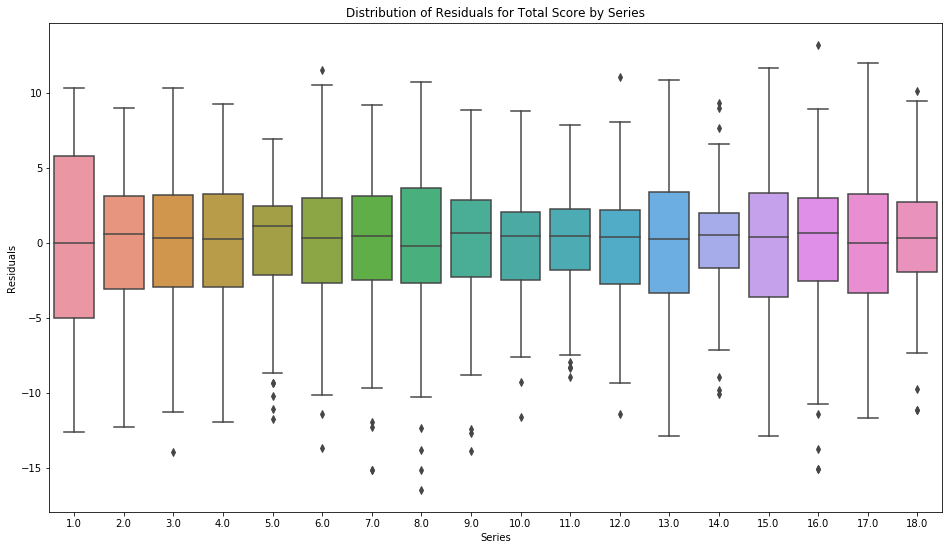

In [17]:
fig = plt.figure(figsize = (16, 9))

ax = sns.boxplot(x = mdf.model.groups, y = mdf.resid)

ax.set_title("Distribution of Residuals for Total Score by Series")
ax.set_ylabel("Residuals")
ax.set_xlabel("Series")

plt.show()

In [18]:
from statsmodels.stats.diagnostic import het_white

het_white_res = het_white(mdf.resid, mdf.model.exog)

labels = ["LM Statistic", "LM-Test p-value", "F-Statistic", "F-Test p-value"]

for key, val in dict(zip(labels, het_white_res)).items():
    print(key, val)

LM Statistic 163.87087283221416
LM-Test p-value 1.4857910293067786e-21
F-Statistic 6.399659088739886
F-Test p-value 2.407794384374526e-22


In [19]:
feature_data = data[['Week', 'Series', 'Order', "Female_celebrity", "Celebrity_BAME", "Age", "Total"]]

feature_data = pd.merge(
    feature_data,
    pd.get_dummies(data["Type"], prefix="Type"),
    left_index=True,
    right_index=True
)

for k in feature_data.keys():
    feature_data[k] = feature_data[k].map(lambda x: string_to_type(x, float))

feature_data = sm.add_constant(feature_data)
feature_data = feature_data.drop("Type_Ballroom", 1)

target_data = np.logical_or(data["Result"] == "Eliminated", data["Result"] == "Bottom two").astype(int)

This is a multilevel logistic regression model that looks at whether the dancers ended up in the bottom two. Since the scores that people get will generally increase week by week and the people ending up in the bottom two are "better" dancers, the different levels of the model are the week numbers in addition to the series numbers this time. 

In [20]:
feature_data_fixed = feature_data[['const', 'Order', 'Female_celebrity', "Celebrity_BAME", 'Age', 'Total',
       'Type_Fusion', 'Type_Latin', 'Type_Speciality']]
feature_data_random = feature_data[["Week", "Series"]]

inds = ~(feature_data_fixed.isnull().any(axis=1))

feature_data = feature_data[inds]
target_data = target_data[inds]
feature_data["Result"] = target_data

logit_model = sm.BinomialBayesMixedGLM.from_formula(
    "Result ~ Order + Female_celebrity + Celebrity_BAME + Age + Total + Type_Fusion + Type_Latin + Type_Speciality",
    {"Week": "1 + Week", "Series": "1 + Series"},
    feature_data
)
logit_res = logit_model.fit_vb(fit_method="BFGS")
print(logit_res.summary())


                  Binomial Mixed GLM Results
                 Type Post. Mean Post. SD   SD  SD (LB) SD (UB)
---------------------------------------------------------------
Intercept           M     1.8752   0.0640                      
Order               M    -0.0969   0.0116                      
Female_celebrity    M     0.1926   0.0898                      
Celebrity_BAME      M     0.5013   0.1445                      
Age                 M     0.0076   0.0016                      
Total               M    -0.2368   0.0022                      
Type_Fusion         M    -0.2178   1.0502                      
Type_Latin          M    -0.3802   0.1061                      
Type_Speciality     M    -0.1017   0.1198                      
Week                V    -0.7931   0.5412 0.452   0.153   1.336
Series              V    -1.5755   0.7354 0.207   0.048   0.901
Parameter types are mean structure (M) and variance structure
(V)
Variance parameters are modeled as log standard deviation

In [21]:
np.exp(logit_res.params[logit_model.exog_names.index("Female_celebrity")])

1.2123897102208427

In [22]:
np.exp(logit_res.params[logit_model.exog_names.index("Celebrity_BAME")])

1.6508699715458994

Women are 21% more likely and BAME people are 65% more likely to be in the dance off, despite both groups getting higher scores from the judges.